In [113]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, roc_curve, auc, roc_auc_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from collections import OrderedDict, Counter
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

sns.set(font_scale=1.2, style='white')

### Load subset data

In [2]:
with open('../data/larger_subset.pkl', 'rb') as f:
    order_sub, prior_sub, recent_sub = pickle.load(f)

In [3]:
order_sub.shape, prior_sub.shape, recent_sub.shape

((83003, 7), (812517, 4), (33952, 4))

In [4]:
recent_sub.order_id.nunique()

3175

In [ ]:
# #Take a 475 orders (~15%) holdout set by order_id in the recent order set and add order information to it

# holdout_order_id = np.random.choice(recent_sub.order_id.unique(), 475, replace=False)

# test_order = order_sub[order_sub.order_id.isin(holdout_order_id)]
# test_order.shape

# train_order = order_sub[(~order_sub.order_id.isin(holdout_order_id)) & (order_sub.eval_set=='train')]
# train_order.shape

# #save train, test set
# with open('data/larger_train_test_df.pkl', 'wb') as f:
#     pickle.dump((train_order, test_order),f)

In [13]:
train_order = order_sub[order_sub.eval_set=='train']

**Add user_id to recent_order to make it easier to search for the prior orders from the proior orders.**

In [5]:
recent_sub1= pd.merge(recent_sub, order_sub[['order_id', 'user_id']], on='order_id', how = 'left')

In [6]:
recent_order_train = recent_sub1

### Baseline model with one feature: how many times the user reordered the order in the past.

In [7]:
prior_details = pd.merge(prior_sub, order_sub[order_sub.eval_set=='prior'], on='order_id', how='right')
prior_summary= prior_details.groupby(['user_id','product_id'], as_index=False).reordered.sum()
prior_summary.rename({'reordered':'user_product_reordered_past'}, axis=1, inplace=True)

In [8]:
prior_summary.head()

,user_id,product_id,user_product_reordered_past
0,33,455,0
1,33,2408,0
2,33,2514,0
3,33,2516,0
4,33,7039,1


In [284]:
with open('data/prior_orders.pkl', 'wb') as f:
    pickle.dump((prior_details, prior_summary), f)

In [9]:
recent_order_train.head(3)

,order_id,product_id,add_to_cart_order,reordered,user_id
0,393,12078,1,1,111860
1,393,6184,2,1,111860
2,393,32403,3,1,111860


In [10]:
recent_order_train.shape

(33952, 5)

Get all the product the user ordered in the past and predict if he will reorder in his recent order. Assign the reordered information (0 or 1) to the prior order (groupby user and product id)

In [14]:
X = prior_summary[prior_summary.user_id.isin(train_order.user_id)]

In [15]:
df = pd.merge(X, recent_order_train[['user_id', 'product_id', 'reordered']], on=['user_id', 'product_id'], how='left')

In [16]:
df['reordered'].fillna(0,inplace=True)

In [17]:
df.shape

(211101, 4)

In [18]:
df.head(3)

,user_id,product_id,user_product_reordered_past,reordered
0,41,226,0,0.0
1,41,1987,1,0.0
2,41,2295,0,0.0


Define a cross validation function to try different features and models. 

In [19]:
def cv_model4(estimator, df, cv=5, scale=False, v=False):
    acc_list=[]
    rec_list=[]
    prec_list=[]
    f1_list=[]
    auc_list=[]
    f1_train=[]  #check train score if see if the model overfits
    i=0
    highest_f1=[]
    if v:
        fig, ax = plt.subplots(1,3, figsize=(15,5))
    
    kf = KFold(n_splits=cv, shuffle=True)
    for user_train_ind, user_val_ind in kf.split(df.user_id.unique()):
    #print(user_train.shape, user_val.shape)
        user_train=df.user_id.unique()[user_train_ind]
        user_val=df.user_id.unique()[user_val_ind]
        df1 = df[df.user_id.isin(user_train)]
        y_train = df1['reordered']
        X_train = df1.drop(columns=['reordered', 'user_id', 'product_id'])
        feature_names=X_train.columns
        df2 = df[df.user_id.isin(user_val)]
        y_val = df2['reordered']
        X_val = df2.drop(columns=['reordered', 'user_id', 'product_id'])    
        #print(user_train.shape, user_val.shape, X_train.shape, X_val.shape, y_train.shape, y_val.shape)
        if scale == True:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)
        lm = estimator
        lm.fit(X_train, y_train)
        y_pred = lm.predict(X_val)
        y_pred_train = lm.predict(X_train)
    
        acc_list.append(accuracy_score(y_val, y_pred))
        rec_list.append(recall_score(y_val, y_pred))
        prec_list.append(precision_score(y_val, y_pred))
        f1_list.append(f1_score(y_val, y_pred))
        f1_train.append(f1_score(y_train, y_pred_train))
        
        y_pred_prob = lm.predict_proba(X_val)[:,1]
        fpr, tpr, _ = roc_curve(y_val, y_pred_prob, pos_label=1)
        auc_list.append(auc(fpr, tpr))
        if v:
            i += 1
            ax[0].plot(fpr, tpr, label='ROC Fold %d' % i)
        rec, prec, thres = precision_recall_curve(y_val, y_pred_prob, pos_label=1)
        if v:
            ax[1].plot(rec, prec, label ='Fold %d' %i)
        f1s = []
        for r, p, t in zip(rec, prec, thres):
            if r and p:
                f1s.append((2*r*p/(r+p), t, r, p))
        if v:
            print('Fold %d highest F1: %.3f at threshold p= %.3f. Recall is %.3f, precision is %.3f' 
                  % (i, *sorted(f1s, reverse=True)[0]))
        highest_f1.append(sorted(f1s, reverse=True)[0][0])
        if v:
            ax[2].plot(list(zip(*f1s))[1], list(zip(*f1s))[0], label='Fold %d' %i)
    if v:        
        plt.legend()
        ax[0].set_xlabel('FPR')
        ax[0].set_ylabel('TPR')
        ax[0].set_title('ROC Curve')
        ax[1].set_xlabel('Recall')
        ax[1].set_ylabel('Precision')
        ax[1].set_title('Precision-Recall Curve')
        ax[2].set_xlabel('P threshold')
        ax[2].set_ylabel('F1 score')
        ax[2].set_title('F1 Score vs. Positive Class Decision Probability Threshold')

    if v:
        mean_acc = np.mean(acc_list)
        std_acc = np.std(acc_list)
        mean_rec = np.mean(rec_list)
        std_rec = np.std(rec_list)
        mean_prec = np.mean(prec_list)
        std_prec = np.std(prec_list) 
        print('mean accuracy: %.3f, std accuracy: %.3f' % (mean_acc, std_acc))
        print('mean recall: %.3f, std recall: %.3f' % (mean_rec, std_rec))  
        print('mean precision: %.3f, std accuracy: %.3f' % (mean_prec, std_prec))
    
    mean_f1 = np.mean(f1_list)
    std_f1 = np.std(f1_list)
    mean_auc = np.mean(auc_list)
    std_auc = np.std(auc_list)
    mean_f1_train = np.mean(f1_train)
    std_f1_train = np.std(f1_train)
    mean_highest_f1 = np.mean(highest_f1)
    std_highest_f1 = np.std(highest_f1)
    print('mean highest_f1: %.3f, std highest_f1: %.3f' % (mean_highest_f1, std_highest_f1))
    print('mean F1: %.3f, std AUC: %.3f' % (mean_f1, std_f1))
    print('mean AUC: %.3f, std AUC: %.3f' % (mean_auc, std_auc))
    print('mean train F1: %.3f, std train F1: %.3f' % (mean_f1_train, std_f1_train))
    return lm, feature_names, mean_highest_f1

Fold 1 highest F1: 0.316 at threshold p= 0.095. Recall is 0.226, precision is 0.525
Fold 2 highest F1: 0.315 at threshold p= 0.108. Recall is 0.250, precision is 0.425
Fold 3 highest F1: 0.312 at threshold p= 0.095. Recall is 0.223, precision is 0.520
Fold 4 highest F1: 0.317 at threshold p= 0.095. Recall is 0.224, precision is 0.538
Fold 5 highest F1: 0.301 at threshold p= 0.109. Recall is 0.237, precision is 0.413
mean accuracy: 0.903, std accuracy: 0.002
mean recall: 0.041, std recall: 0.005
mean precision: 0.466, std accuracy: 0.048
mean highest_f1: 0.312, std highest_f1: 0.006
mean F1: 0.075, std AUC: 0.009
mean AUC: 0.710, std AUC: 0.002
mean train F1: 0.075, std train F1: 0.005


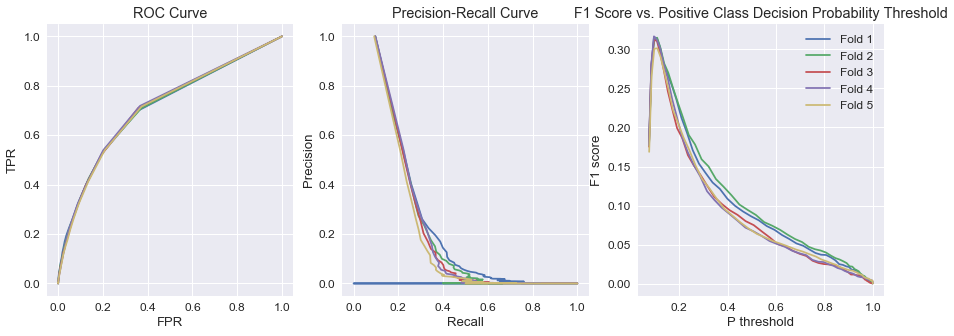

In [20]:
cv_model4(LogisticRegression(), df=df, scale=True, v=True);

**The baseline model has an average F1 score at 0.31. **

### Add features

#### Add user-features.
**1. total_order **  
**2. total_product **  
**2. ave_cart_size **    
**3. how likely the customer shops at weekend vs during the week(convert weekend to 1, weekdays 1, and take average) - user_likely_dow**  
**5. ave_days_since_prior_order(tried median, doesnt work as well as mean)**    
**6. total unique product - user_total_uniq_product**  
**7. percentage of total product that purchased only once - total_uniq_over_total_product**

In [21]:
#convert dow to weekend 1(0,1), weekday 0(2-6), then take average
prior_details_feature = prior_details.copy()
prior_details_feature['dow_binary'] = (prior_details_feature.order_dow < 2 ).astype(int)

In [22]:
user_feature_temp = (prior_details_feature.groupby(['user_id', 'order_id'], as_index=False)
                .agg(OrderedDict([('product_id', 'count'), ('days_since_prior_order', 'first'), 
                                  ('dow_binary', 'first')])))

In [23]:
user_feature_temp.rename(columns={'product_id': 'total_product'}, inplace=True)

In [24]:
user_feature = (user_feature_temp.groupby(['user_id'], as_index=False)
                .agg(OrderedDict([('order_id','count'), ('total_product', ['mean', 'sum']), ('days_since_prior_order', 'mean'), 
                                 ('dow_binary', 'mean')])))

In [25]:
user_feature_colname = ['user_id', 'user_total_order', 'user_cart_size', 'user_total_product','user_ave_days_since_last_order', 
                        'user_likely_dow']
user_feature.columns = user_feature_colname

In [26]:
user_feature.head()

,user_id,user_total_order,user_cart_size,user_total_product,user_ave_days_since_last_order,user_likely_dow
0,33,3,17.666667,53,28.500000,0.333333
1,41,5,13.000000,65,25.750000,0.600000
2,70,13,8.000000,104,19.083333,0.153846
3,160,12,22.083333,265,14.636364,0.583333
4,207,3,7.333333,22,22.000000,0.333333


In [27]:
user_uniq_product = prior_details.groupby('user_id')['product_id'].nunique()
user_feature = pd.merge(user_feature, user_uniq_product.to_frame(), left_on ='user_id', 
                        right_index=True, how='left')
user_feature.rename(columns={'product_id': 'user_total_uniq_product'}, inplace=True)

In [28]:
user_feature['user_uniq_prod_over_total_prod'] = \
user_feature['user_total_uniq_product']/user_feature['user_total_product']

In [29]:
user_feature.head(3)

,user_id,user_total_order,user_cart_size,user_total_product,user_ave_days_since_last_order,user_likely_dow,user_total_uniq_product,user_uniq_prod_over_total_prod
0,33,3,17.666667,53,28.500000,0.333333,34,0.641509
1,41,5,13.000000,65,25.750000,0.600000,47,0.723077
2,70,13,8.000000,104,19.083333,0.153846,71,0.682692


**Merge user feature to the df and try Logistic Regression**

In [30]:
df_user = pd.merge(df, user_feature, on='user_id', how='left')

In [31]:
f1s=[]
for c in [0.1, 1, 10, 100]:
    print('C=%f' % c)
    lm, feature_names, f1 = cv_model4(LogisticRegression(penalty='l1', C=c), df=df_user, 
                                                                 cv=5, scale=True, v=False)
    f1s.append((f1, c, lm, feature_names))
print('Higest f1 score:', sorted(f1s, reverse=True)[0][:2])

C=0.100000
mean highest_f1: 0.370, std highest_f1: 0.006
mean F1: 0.109, std AUC: 0.011
mean AUC: 0.761, std AUC: 0.007
mean train F1: 0.109, std train F1: 0.001
C=1.000000
mean highest_f1: 0.369, std highest_f1: 0.010
mean F1: 0.109, std AUC: 0.007
mean AUC: 0.761, std AUC: 0.007
mean train F1: 0.109, std train F1: 0.004
C=10.000000
mean highest_f1: 0.370, std highest_f1: 0.007
mean F1: 0.108, std AUC: 0.013
mean AUC: 0.761, std AUC: 0.003
mean train F1: 0.109, std train F1: 0.003
C=100.000000
mean highest_f1: 0.370, std highest_f1: 0.011
mean F1: 0.110, std AUC: 0.008
mean AUC: 0.761, std AUC: 0.003
mean train F1: 0.109, std train F1: 0.002
Higest f1 score: (0.37004918589680963, 100)


**User features improved f1 score of prediction a little bit.
### Add Product Features
**1. Product total reordered count - product_total_reorders**  
**2. Total counts of the product were ordered in the past - product_total_orders**   
**3. Averge product add to cart order - product_avg_add_to_cart_order**      
**4. Percentage of reorder in total product - product_percent_reordered_past** 

(department and aisle are categorical, need to convert to dummie variables, add later)
  - department
  - aisle

In [32]:
prod_feature = ['product_total_orders', 'product_avg_add_to_cart_order']
prod_features_df = prior_details.groupby('product_id', as_index=False).agg(OrderedDict([('order_id','count'), 
                                                                     ('add_to_cart_order', 'mean')]))
prod_features_df.columns = ['product_id'] + prod_feature
prod_features_df.head()

,product_id,product_total_orders,product_avg_add_to_cart_order
0,1,106,7.820755
1,2,3,5.666667
2,3,2,3.000000
3,4,5,15.200000
4,7,1,9.000000


In [33]:
df_prod = pd.merge(df_user, prod_features_df, on='product_id', how='left')

In [34]:
f1s=[]
for c in [0.1, 1, 10, 100]:
    print('C=%f' % c)
    lm, feature_names, f1 = cv_model4(LogisticRegression(penalty='l1', C=c), df=df_prod, 
                                                                 cv=5, scale=True, v=False)
    f1s.append((f1, c, lm, feature_names))
print('Higest f1 score:', sorted(f1s, reverse=True)[0][:2])

C=0.100000
mean highest_f1: 0.368, std highest_f1: 0.004
mean F1: 0.120, std AUC: 0.010
mean AUC: 0.764, std AUC: 0.008
mean train F1: 0.121, std train F1: 0.002
C=1.000000
mean highest_f1: 0.368, std highest_f1: 0.005
mean F1: 0.121, std AUC: 0.013
mean AUC: 0.764, std AUC: 0.008
mean train F1: 0.121, std train F1: 0.002
C=10.000000
mean highest_f1: 0.368, std highest_f1: 0.011
mean F1: 0.121, std AUC: 0.012
mean AUC: 0.764, std AUC: 0.003
mean train F1: 0.121, std train F1: 0.002
C=100.000000
mean highest_f1: 0.369, std highest_f1: 0.008
mean F1: 0.121, std AUC: 0.010
mean AUC: 0.764, std AUC: 0.006
mean train F1: 0.121, std train F1: 0.002
Higest f1 score: (0.36855422489903955, 100)


In [35]:
df_prod.head(2)

,user_id,product_id,user_product_reordered_past,reordered,user_total_order,user_cart_size,user_total_product,user_ave_days_since_last_order,user_likely_dow,user_total_uniq_product,user_uniq_prod_over_total_prod,product_total_orders,product_avg_add_to_cart_order
0,41,226,0,0.0,5,13.0,65,25.75,0.6,47,0.723077,38,10.657895
1,41,1987,1,0.0,5,13.0,65,25.75,0.6,47,0.723077,6,6.666667


In [36]:
prod_reordered=df_prod.groupby('product_id', as_index=False)['user_product_reordered_past'].sum()
df_prod_temp=pd.merge(df_prod, prod_reordered, on='product_id', how='left')
df_prod_temp.rename(columns={'user_product_reordered_past_x':'user_product_reordered_past', 
                             'user_product_reordered_past_y':'product_past_reordered_count'}, inplace=True)

In [37]:
df_prod_temp['product_percent_reordered_past'] = (df_prod_temp['product_past_reordered_count']/  #no 0 total product(chedked) 
                                                  df_prod_temp['product_total_orders']*100)

In [38]:
df_prod=df_prod_temp.copy()
del df_prod_temp

In [39]:
f1s=[]
for c in [0.01, 0.1, 1, 10, 100]:
    print('C=%f' % c)
    lm, feature_names, f1= cv_model4(LogisticRegression(penalty='l1', C=c), 
                                  df=df_prod, cv=5, scale=True, v=False)
    f1s.append((f1, c, lm, feature_names))
print('Higest f1 score:', sorted(f1s, reverse=True)[0][:2])

C=0.010000
mean highest_f1: 0.367, std highest_f1: 0.005
mean F1: 0.114, std AUC: 0.009
mean AUC: 0.769, std AUC: 0.003
mean train F1: 0.114, std train F1: 0.005
C=0.100000
mean highest_f1: 0.366, std highest_f1: 0.008
mean F1: 0.115, std AUC: 0.012
mean AUC: 0.768, std AUC: 0.005
mean train F1: 0.116, std train F1: 0.003
C=1.000000
mean highest_f1: 0.366, std highest_f1: 0.010
mean F1: 0.116, std AUC: 0.010
mean AUC: 0.768, std AUC: 0.007
mean train F1: 0.116, std train F1: 0.004
C=10.000000
mean highest_f1: 0.365, std highest_f1: 0.006
mean F1: 0.116, std AUC: 0.009
mean AUC: 0.768, std AUC: 0.007
mean train F1: 0.116, std train F1: 0.005
C=100.000000
mean highest_f1: 0.365, std highest_f1: 0.007
mean F1: 0.117, std AUC: 0.012
mean AUC: 0.768, std AUC: 0.005
mean train F1: 0.117, std train F1: 0.002
Higest f1 score: (0.3665384926240155, 0.01)


### Add user-product feature.
**1. ave_add_to_cart_order**   
**2. user_product_ordered_last_n_order - how many orders ago is the last time the user ordered that product**   
**3. user_product_ave_days_since_prior_order**  
**4. ave_days_between_product_order (product_order_interval)**  
**5. user_product_ave_add_to_cart_order_scale(average of add to cart over scaled within each user)**   
**6. user_product_ave_add_to_cart_order (not scaled)**  
**7. user_product_percent_order_containing_product** 
**8. user_product_days_since_last_product_order**
**9. on average how many days between the user ordered the product - user_product_ave_day_per_product_order**  
**11. user_product_ave_day_between_product_order_versus_current_day_since_prior - ratio between average days the user purchase a product vs days since last order**  
**12. user_product_ordered_same_day - has the user order the same product that day.**   
**13. ave_add_to_cart_order_scale_x_reorder_count (for logistic regression)**  


Scale the add to cart order and then take the average

In [40]:
prior_details_feature['user_product_add_to_cart_order_scale']=(prior_details_feature.groupby('order_id')['add_to_cart_order']
                                                               .transform(lambda x: x/max(x)))


In [41]:
user_product_feature = (prior_details_feature.groupby(['user_id', 'product_id'], as_index=False)
                       .agg(OrderedDict([('add_to_cart_order', 'mean'), ('user_product_add_to_cart_order_scale', 'mean'),('days_since_prior_order', 'mean'),
                                        ('order_number', 'max')])))
user_product_feature.rename(columns={'add_to_cart_order': 'user_product_ave_add_to_cart_order', 
                                     'user_product_add_to_cart_order_scale':'user_product_ave_add_to_cart_order_scale',
                                    'days_since_prior_order':'user_product_ave_days_since_prior_order',
                                    'order_number':'user_product_most_recent_order'}, inplace=True)

In [42]:
user_product_feature_bk = user_product_feature

In [43]:
user_product_feature.head(3)

,user_id,product_id,user_product_ave_add_to_cart_order,user_product_ave_add_to_cart_order_scale,user_product_ave_days_since_prior_order,user_product_most_recent_order
0,33,455,15.0,0.882353,30.0,3
1,33,2408,11.0,0.478261,NaN,1
2,33,2514,17.0,1.000000,30.0,3


In [44]:
upf = pd.merge(user_product_feature, user_feature[['user_id', 'user_total_order']], 
               on='user_id', how='left')
upf['user_product_ordered_last_n_order'] = (upf['user_total_order']
                                            -upf['user_product_most_recent_order'])
upf.drop(columns='user_total_order', inplace=True)

In [45]:
upf.head(3)

,user_id,product_id,user_product_ave_add_to_cart_order,user_product_ave_add_to_cart_order_scale,user_product_ave_days_since_prior_order,user_product_most_recent_order,user_product_ordered_last_n_order
0,33,455,15.0,0.882353,30.0,3,0
1,33,2408,11.0,0.478261,NaN,1,2
2,33,2514,17.0,1.000000,30.0,3,0


Calculate days since last time the user ordered the product.

In [46]:
#prior_order
df_temp=(prior_details.groupby(['user_id', 'order_number'], as_index=False)
.agg(OrderedDict([('order_id', 'first'),('days_since_prior_order', 'first')]))
.sort_values(['user_id', 'order_number'], ascending=[True, False]))
df_temp['cumulative_days_since_nth_order'] = (df_temp.groupby('user_id', as_index=False)['days_since_prior_order']
                                              .cumsum())

**The prior days of the first order is null. fill NA with ffill with addtional 7 days (a week). The rational to use short period versus long period for the cases that the user is new to Instacart.**

In [47]:
a = df_temp['cumulative_days_since_nth_order'].fillna(method='ffill').copy()
a[df_temp['cumulative_days_since_nth_order'].isnull()] +=7

In [48]:
df_temp['cumulative_days_since_nth_order']=a.copy()

In [49]:
user_product_feature = pd.merge(upf, df_temp.drop(columns=['order_id', 'days_since_prior_order']), 
                    left_on=['user_id', 'user_product_most_recent_order'], right_on = ['user_id', 'order_number'],
                    how='left')
user_product_feature.drop(columns=['user_product_most_recent_order','order_number'],inplace=True)

In [50]:
user_product_feature.rename(columns={'cumulative_days_since_nth_order'
                                     :'user_product_days_since_last_product_order'}, inplace=True)

**user_product_ave_days_since_prior_order have NAs. Those are the product the customers ordered only once (in the very first order. Fill NA with user_product_cumulative_days_since_nth_order for the produce (maximum period that the user didn't order the product in this data set.**

In [51]:
user_product_feature['user_product_ave_days_since_prior_order'].fillna(user_product_feature['user_product_days_since_last_product_order'], inplace=True)

In [52]:
user_product_feature.head(2)

,user_id,product_id,user_product_ave_add_to_cart_order,user_product_ave_add_to_cart_order_scale,user_product_ave_days_since_prior_order,user_product_ordered_last_n_order,user_product_days_since_last_product_order
0,33,455,15.0,0.882353,30.0,0,30.0
1,33,2408,11.0,0.478261,64.0,2,64.0


Add feature 'user_product_percent_order_containing_product' 

In [53]:
df_up = pd.merge(df_prod, user_product_feature, on=['user_id', 'product_id'], how='left')
df_up['user_product_percent_order_containing_product'] = ((df_up['user_product_reordered_past'] + 1)
                                                        / df_up['user_total_order'])

In [54]:
f1s=[]
for c in [0.01, 0.1, 1, 10, 100]:
    print('C=%f' % c)
    lm, feature_names, f1= cv_model4(LogisticRegression(penalty='l2', solver='sag', C=c), 
                                  df=df_up, cv=5, scale=True, v=False)
    f1s.append((f1, c, lm, feature_names))
print('Higest f1 score:', sorted(f1s, reverse=True)[0][:2])

C=0.010000
mean highest_f1: 0.418, std highest_f1: 0.008
mean F1: 0.239, std AUC: 0.011
mean AUC: 0.818, std AUC: 0.004
mean train F1: 0.240, std train F1: 0.002
C=0.100000
mean highest_f1: 0.418, std highest_f1: 0.012
mean F1: 0.240, std AUC: 0.011
mean AUC: 0.818, std AUC: 0.007
mean train F1: 0.241, std train F1: 0.005
C=1.000000
mean highest_f1: 0.418, std highest_f1: 0.013
mean F1: 0.240, std AUC: 0.021
mean AUC: 0.818, std AUC: 0.008
mean train F1: 0.241, std train F1: 0.006
C=10.000000
mean highest_f1: 0.419, std highest_f1: 0.008
mean F1: 0.240, std AUC: 0.008
mean AUC: 0.818, std AUC: 0.004
mean train F1: 0.241, std train F1: 0.003
C=100.000000
mean highest_f1: 0.418, std highest_f1: 0.004
mean F1: 0.241, std AUC: 0.008
mean AUC: 0.818, std AUC: 0.005
mean train F1: 0.241, std train F1: 0.003
Higest f1 score: (0.4185088904245456, 10)


Add on average how many days between the user ordered the product

In [55]:
days_since_first_order = (prior_details.groupby(['user_id','order_id'], as_index=False)
                          .agg(OrderedDict([('days_since_prior_order', 'first')]))
 .groupby('user_id', as_index=False)['days_since_prior_order'].sum())

In [56]:
days_since_first_order.rename(columns={'days_since_prior_order':'days_since_first_order'}, inplace=True)

In [57]:
days_since_first_order.head(2)

,user_id,days_since_first_order
0,33,57.0
1,41,103.0


In [58]:
df_up1 = pd.merge(df_up, days_since_first_order, on='user_id', how='left')
df_up1['user_product_ave_day_per_product_order'] = df_up1['days_since_first_order']/(df_up1['user_product_reordered_past']+1)

In [59]:
df_up1.drop(columns='days_since_first_order', inplace=True)

Add feature - user_product_ave_day_between_product_order_versus_current_day_since_prior
how long ago the customer order the produce versus how long ago he last time ordered

In [60]:
order_sub.head(1)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
476,2906103,33,prior,1,3,14,NaN


In [61]:
df_up2 = pd.merge(df_up1, order_sub[order_sub['eval_set']=='train'].drop(
    columns=['order_id', 'eval_set', 'order_number']), on = 'user_id', how='left')

In [62]:
df_up2.rename(columns={'days_since_prior_order':'current_days_since_prior_order'},inplace=True)

In [63]:
df_up2.shape, df_up1.shape

((211101, 25), (211101, 22))

In [64]:
def get_ratio(row):
    a = row['user_product_ave_day_per_product_order']
    b = row['current_days_since_prior_order']
    if a == 0:
        a+=0.5
    if b == 0:
        b+=0.5
    return a/b
        

In [65]:
df_up2['user_product_ave_day_between_product_order_versus_current_day_since_prior']=\
df_up2.apply(get_ratio, axis=1)

Add feature - if the user order the item the same day.

In [66]:
df_up3 = pd.merge(df_up2, user_product_feature_bk[['user_id', 'product_id', 'user_product_most_recent_order']],
                 on=['user_id', 'product_id'], how='left')

In [67]:
def order_same_day(row):
    if row['current_days_since_prior_order'] == 0 and \
    row['user_total_order'] == row['user_product_most_recent_order']:
        return 1
    else:
        return 0

In [68]:
df_up3['user_product_ordered_same_day']=df_up3.apply(order_same_day, axis=1)

In [69]:
df_up3.drop(columns='user_product_most_recent_order', inplace=True)

Try Logistic Regresion on cross validation

In [70]:
f1s=[]
for c in [0.01, 0.1, 1, 10]:
    print('C=%f' % c)
    lm, feature_names, f1= cv_model4(LogisticRegression(penalty='l2', solver='sag', C=c), 
                                  df=df_up3, cv=5, scale=True, v=False)
    f1s.append((f1, c, lm, feature_names))
print('Higest f1 score:', sorted(f1s, reverse=True)[0][:2])

C=0.010000
mean highest_f1: 0.422, std highest_f1: 0.005
mean F1: 0.242, std AUC: 0.008
mean AUC: 0.821, std AUC: 0.005
mean train F1: 0.242, std train F1: 0.004
C=0.100000
mean highest_f1: 0.422, std highest_f1: 0.006
mean F1: 0.240, std AUC: 0.008
mean AUC: 0.821, std AUC: 0.004
mean train F1: 0.243, std train F1: 0.004
C=1.000000
mean highest_f1: 0.421, std highest_f1: 0.009
mean F1: 0.241, std AUC: 0.009
mean AUC: 0.821, std AUC: 0.005
mean train F1: 0.243, std train F1: 0.005
C=10.000000
mean highest_f1: 0.422, std highest_f1: 0.004
mean F1: 0.242, std AUC: 0.013
mean AUC: 0.821, std AUC: 0.005
mean train F1: 0.242, std train F1: 0.004
Higest f1 score: (0.42204929369641386, 0.1)


In [71]:
model, feature = sorted(f1s,reverse=True)[0][2:4]
feature = feature.astype('str')
for i, j in sorted(zip(model.coef_[0], feature), reverse=True):
    print(i,j)

0.43254271654725035 product_total_orders
0.4321807116718714 user_product_percent_order_containing_product
0.16271529447652694 product_percent_reordered_past
0.1308932577828716 user_total_uniq_product
0.126272026545736 user_ave_days_since_last_order
0.12047844829200448 user_product_ordered_same_day
0.09054466814693965 user_product_ave_days_since_prior_order
0.054154572259212524 user_product_ave_add_to_cart_order
0.013075115540142459 user_likely_dow
0.009964363589117797 user_product_reordered_past
-0.01788320996879672 current_days_since_prior_order
-0.021785940167277907 order_hour_of_day
-0.026858793088843362 order_dow
-0.03263699207082366 user_cart_size
-0.09970349303189008 user_total_product
-0.10676197871019454 user_total_order
-0.1085343604217698 user_product_ave_add_to_cart_order_scale
-0.11422890490211295 product_avg_add_to_cart_order
-0.1728106025558191 user_product_ave_day_per_product_order
-0.1891585388693282 user_product_ave_day_between_product_order_versus_current_day_since_pr

Add dummie variable

In [73]:
product_df=pd.read_csv('../data/products.csv')

In [74]:
product_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [75]:
df_dept=pd.merge(df_up3, product_df, on='product_id', how='left')

In [76]:
df_dept.shape

(211101, 30)

In [77]:
dept_dummie=pd.get_dummies(df_dept['department_id'])

In [78]:
dept_col=[]
for col in dept_dummie.columns:
    dept_col.append('product_dept_'+str(col))

In [79]:
dept_dummie.columns=dept_col

In [80]:
df_dept = pd.concat([df_dept.drop(columns='department_id'), dept_dummie], axis=1)

In [81]:
df_dept.head()

,user_id,product_id,user_product_reordered_past,reordered,user_total_order,user_cart_size,user_total_product,user_ave_days_since_last_order,user_likely_dow,user_total_uniq_product,...,product_dept_12,product_dept_13,product_dept_14,product_dept_15,product_dept_16,product_dept_17,product_dept_18,product_dept_19,product_dept_20,product_dept_21
0,41,226,0,0.0,5,13.0,65,25.75,0.6,47,...,0,0,0,0,1,0,0,0,0,0
1,41,1987,1,0.0,5,13.0,65,25.75,0.6,47,...,0,0,0,0,0,0,0,0,0,0
2,41,2295,0,0.0,5,13.0,65,25.75,0.6,47,...,0,0,0,0,0,0,0,0,0,0
3,41,4605,0,1.0,5,13.0,65,25.75,0.6,47,...,0,0,0,0,0,0,0,0,0,0
4,41,5383,0,0.0,5,13.0,65,25.75,0.6,47,...,0,0,0,0,0,0,0,0,0,0


In [82]:
f1s=[]
for c in [0.01, 0.1, 1, 10]:
    print('C=%f' % c)
    lm, feature_names, f1= cv_model4(LogisticRegression(penalty='l2', solver='sag', C=c), 
                                  df=df_dept.drop(columns=['product_name','aisle_id']), 
                                     cv=5, scale=True, v=False)
    f1s.append((f1, c, lm, feature_names))
print('Higest f1 score:', sorted(f1s, reverse=True)[0][:2])

C=0.010000
mean highest_f1: 0.422, std highest_f1: 0.009
mean F1: 0.240, std AUC: 0.013
mean AUC: 0.822, std AUC: 0.007
mean train F1: 0.242, std train F1: 0.005
C=0.100000
mean highest_f1: 0.423, std highest_f1: 0.011
mean F1: 0.241, std AUC: 0.009
mean AUC: 0.822, std AUC: 0.006
mean train F1: 0.243, std train F1: 0.005
C=1.000000
mean highest_f1: 0.422, std highest_f1: 0.003
mean F1: 0.242, std AUC: 0.014
mean AUC: 0.822, std AUC: 0.003
mean train F1: 0.242, std train F1: 0.004
C=10.000000
mean highest_f1: 0.423, std highest_f1: 0.004
mean F1: 0.241, std AUC: 0.008
mean AUC: 0.822, std AUC: 0.007
mean train F1: 0.243, std train F1: 0.002
Higest f1 score: (0.42304574105784065, 10)


In [83]:
model, feature = sorted(f1s,reverse=True)[0][2:4]
feature = feature.astype('str')
for i, j in sorted(zip(model.coef_[0], feature), reverse=True):
    print(i,j)

0.43186794720482125 user_product_percent_order_containing_product
0.33478428972633 product_total_orders
0.13668057854058055 user_ave_days_since_last_order
0.12527263065998875 user_product_ordered_same_day
0.11661827103781337 product_percent_reordered_past
0.10593796943131116 user_total_uniq_product
0.0914996157408924 user_product_ave_days_since_prior_order
0.05578991455500446 product_dept_16
0.04656839390481835 product_dept_7
0.03596899196290827 product_dept_4
0.028490055061285772 product_dept_3
0.02803453317800155 user_product_ave_add_to_cart_order
0.02697471964495995 product_dept_19
0.019562088700343566 user_likely_dow
0.01645410943125895 product_dept_8
0.01560918419614311 user_product_reordered_past
0.013259135202895532 product_dept_21
0.005462710277826371 product_dept_20
0.004820812101428557 product_dept_12
0.004239677512069952 product_dept_5
-0.00010001892001902742 product_dept_14
-0.00022040653468993453 product_dept_10
-0.007522506586728986 product_dept_1
-0.007819673992498857 cu

In [84]:
aisle_dummies= pd.get_dummies(df_dept['aisle_id'])

In [85]:
aisle_col=[]
for col in aisle_dummies.columns:
    aisle_col.append('product_aisle_'+str(col))

In [86]:
aisle_dummies.columns=aisle_col

In [87]:
df_aisle=pd.concat([df_dept.drop(columns='product_name'), aisle_dummies], axis=1)

In [88]:
f1s=[]
for c in [0.01, 0.1, 1, 10]:
    print('C=%f' % c)
    lm, feature_names, f1= cv_model4(LogisticRegression(penalty='l2', solver='sag', C=c), 
                                  df=df_aisle, 
                                     cv=5, scale=True, v=False)
    f1s.append((f1, c, lm, feature_names))
print('Higest f1 score:', sorted(f1s, reverse=True)[0][:2])

C=0.010000
mean highest_f1: 0.423, std highest_f1: 0.009
mean F1: 0.244, std AUC: 0.010
mean AUC: 0.822, std AUC: 0.002
mean train F1: 0.245, std train F1: 0.004
C=0.100000


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


mean highest_f1: 0.423, std highest_f1: 0.006
mean F1: 0.243, std AUC: 0.004
mean AUC: 0.822, std AUC: 0.002
mean train F1: 0.246, std train F1: 0.001
C=1.000000
mean highest_f1: 0.422, std highest_f1: 0.012
mean F1: 0.246, std AUC: 0.011
mean AUC: 0.822, std AUC: 0.004
mean train F1: 0.246, std train F1: 0.004
C=10.000000
mean highest_f1: 0.423, std highest_f1: 0.003
mean F1: 0.245, std AUC: 0.012
mean AUC: 0.823, std AUC: 0.003
mean train F1: 0.246, std train F1: 0.003
Higest f1 score: (0.42311718651025354, 0.1)


Adding department or aisle dummies doens't improve the model

Add polynomial terms

In [89]:
df_logit=df_aisle.copy()

In [90]:
df_logit['user_product_reordered_past^2'] = df_logit['user_product_reordered_past']**2

In [91]:
df_logit['user_product_days_since_last_product_order^2']=df_logit['user_product_days_since_last_product_order']**2

In [92]:
df_logit['user_product_percent_order_containing_product_log']=\
np.log(df_logit['user_product_percent_order_containing_product'])

In [93]:
for col in ['user_product_days_since_last_product_order', 'user_product_ordered_last_n_order',
           'user_product_ave_days_since_prior_order','user_product_ave_add_to_cart_order', 
            'user_product_reordered_past',
           'product_past_reordered_count' ]:
    name = col + '_log'
    if df_logit[col].min() == 0:
        df_logit[name] = np.log(df_logit[col]+1)
    else:
        df_logit[name] = np.log(df_logit[col])

In [94]:
f1s=[]
for c in [0.01, 0.1, 1, 10]:
    print('C=%f' % c)
    lm, feature_names, f1= cv_model4(LogisticRegression(penalty='l2', solver='sag', C=c), 
                                  df=df_aisle, 
                                     cv=5, scale=True, v=False)
    f1s.append((f1, c, lm, feature_names))
print('Higest f1 score:', sorted(f1s, reverse=True)[0][:2])

C=0.010000
mean highest_f1: 0.422, std highest_f1: 0.006
mean F1: 0.242, std AUC: 0.004
mean AUC: 0.822, std AUC: 0.004
mean train F1: 0.246, std train F1: 0.004
C=0.100000


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


mean highest_f1: 0.422, std highest_f1: 0.004
mean F1: 0.243, std AUC: 0.006
mean AUC: 0.822, std AUC: 0.005
mean train F1: 0.246, std train F1: 0.004
C=1.000000
mean highest_f1: 0.422, std highest_f1: 0.008
mean F1: 0.244, std AUC: 0.011
mean AUC: 0.822, std AUC: 0.004
mean train F1: 0.246, std train F1: 0.006
C=10.000000
mean highest_f1: 0.422, std highest_f1: 0.008
mean F1: 0.244, std AUC: 0.011
mean AUC: 0.822, std AUC: 0.005
mean train F1: 0.247, std train F1: 0.003
Higest f1 score: (0.42244495032410223, 0.01)


The interaction term and polynomial term doesn't improve the logistic regression model either. Switch to tree model and bin catagorical feature.

In [95]:
product_df=pd.read_csv('../data/products.csv')
product_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [96]:
df_dept=pd.merge(df_up3, product_df, on='product_id', how='left')
df_dept.drop(columns='product_name', inplace=True)

In [97]:
no = df_dept.loc[df_dept['reordered']==0,'department_id'].value_counts().sort_index()/\
df_dept.loc[df_dept['reordered']==0,'department_id'].count()
re = df_dept.loc[df_dept['reordered']==1,'department_id'].value_counts().sort_index()/\
df_dept.loc[df_dept['reordered']==1,'department_id'].count()

Take a look to see how department affect reorder.

In [103]:
dept = pd.read_csv('../data/departments.csv')

In [107]:
dept_freq  = pd.DataFrame(no)
dept_freq.columns=['no_reorder']
dept_freq = pd.merge(dept_freq, re.to_frame(), left_index=True, right_index=True, how='outer')

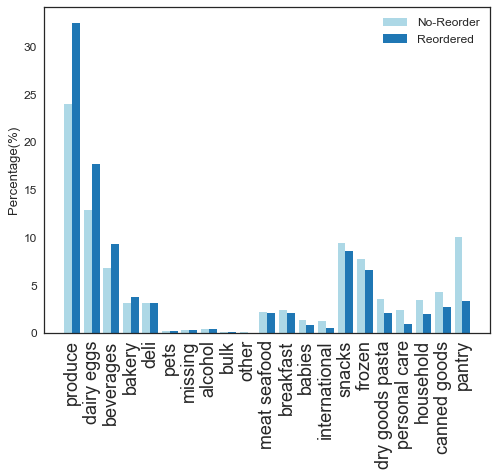

In [114]:
x=np.arange(len(dept_freq))
plt.figure(figsize=(8,6))
plt.bar(x, dept_freq['no_reorder']*100, width=0.4, label='No-Reorder', color='lightblue')
plt.bar(x+0.4, dept_freq['reordered']*100, width=0.4, label = 'Reordered', color='tab:blue')
plt.legend();
plt.ylabel('Percentage(%)')
plt.xticks(fontsize=18)
plt.xticks(x+0.2,dept.loc[dept_freq.index-1, 'department'], rotation=90);

In [110]:
dept_freq.rename(columns={'department_id':'reordered'}, inplace =True)
dept_freq['diff'] = dept_freq['reordered'] - dept_freq['no_reorder']

In [111]:
dept_freq.sort_values('diff', ascending=False, inplace=True)

In [116]:
dept_freq['dept_bin']=0
dept_freq.loc[(dept_freq['diff']>=0.02), 'dept_bin'] = 2
dept_freq.loc[(dept_freq['diff']<0.02) & (dept_freq['diff']>= 0 ),  'dept_bin'] = 1
dept_freq.loc[(dept_freq['diff']<0) & (dept_freq['diff']>= -0.01 ),  'dept_bin'] = -1
dept_freq.loc[(dept_freq['diff']<-0.01) & (dept_freq['diff']>= -0.02 ),  'dept_bin'] = -2
dept_freq.loc[(dept_freq['diff']<-0.02),  'dept_bin'] = -3

In [118]:
dept_map= dept_freq['dept_bin']
df_dept['product_dept_bin'] = df_dept['department_id'].map(dept_map)

In [119]:
df_dept.drop(columns='department_id', inplace=True)

Bin aisle

In [120]:
no = df_dept.loc[df_dept['reordered']==0,'aisle_id'].value_counts().sort_index()/\
df_dept.loc[df_dept['reordered']==0,'aisle_id'].count()
re = df_dept.loc[df_dept['reordered']==1,'aisle_id'].value_counts().sort_index()/\
df_dept.loc[df_dept['reordered']==1,'aisle_id'].count()

In [121]:
aisle_freq  = pd.DataFrame(no)
aisle_freq.columns=['no_reorder']
aisle_freq = pd.merge(aisle_freq, re.to_frame(), left_index=True, right_index=True, how='outer')

In [122]:
aisle_freq.fillna(0, inplace=True)
aisle_freq.rename(columns={'aisle_id':'reordered'}, inplace =True)
aisle_freq['diff'] = aisle_freq['reordered'] - aisle_freq['no_reorder']

In [123]:
aisle_freq['product_aisle_bin'] = 0

aisle_freq.loc[aisle_freq['diff']>=0.001, 'product_aisle_bin'] = 2

aisle_freq.loc[aisle_freq['diff']<=-0.001, 'product_aisle_bin'] = -2

aisle_freq.loc[(aisle_freq['diff']<0.001) & (aisle_freq['diff']>=0), 'product_aisle_bin'] = 1

aisle_freq.loc[(aisle_freq['diff']>-0.001) & (aisle_freq['diff']<0), 'product_aisle_bin'] = -1

In [124]:
aisle_freq.product_aisle_bin.value_counts()

-1    50
-2    48
 1    19
 2    17
Name: product_aisle_bin, dtype: int64

In [125]:
aisle_map = aisle_freq['product_aisle_bin']

In [126]:
df_aisle=df_dept.copy()

In [127]:
df_aisle['product_aisle_bin'] = df_aisle['aisle_id'].map(aisle_map)
df_aisle.drop(columns='aisle_id', inplace=True)

Bin hour of day in the current order

In [128]:
no = df_aisle.loc[df_aisle['reordered']==0,'order_hour_of_day'].value_counts().sort_index()/\
df_aisle.loc[df_aisle['reordered']==0,'order_hour_of_day'].count()
re =df_aisle.loc[df_aisle['reordered']==1,'order_hour_of_day'].value_counts().sort_index()/\
df_aisle.loc[df_aisle['reordered']==1,'order_hour_of_day'].count()

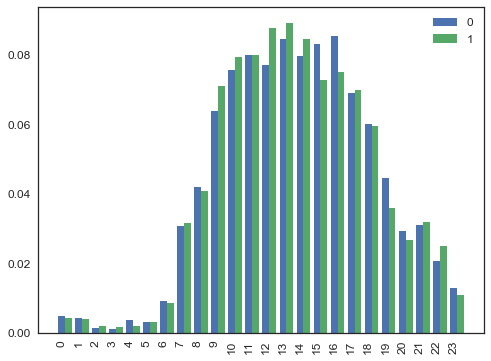

In [129]:
x1=np.arange(len(no))
x2= np.arange(len(re))
plt.figure(figsize=(8,6))
plt.bar(x1, no, width=0.4, label='0')
plt.bar(x2+0.4, re, width=0.4, label = '1')
plt.legend();
plt.xticks(np.arange(0,len(no)),no.index, rotation=90);

In [130]:
product_hod_freq = pd.DataFrame(no)
product_hod_freq.columns=['no_reorder']
product_hod_freq = pd.concat([product_hod_freq, re.to_frame()], axis=1)
product_hod_freq.rename(columns={'order_hour_of_day':'reordered'}, inplace=True)
product_hod_freq['diff'] = product_hod_freq['reordered'] - product_hod_freq['no_reorder']

In [131]:
product_hod_freq['user_current_hod_bin'] = 0
product_hod_freq.loc[(product_hod_freq['diff']>=0), 'user_current_hod_bin']=1
product_hod_freq.loc[(product_hod_freq['diff']<0), 'user_current_hod_bin']=-1

In [132]:
df_hod= df_aisle.copy()

In [133]:
product_hod_freq['user_current_hod_bin'].describe()

count    24.000000
mean      0.083333
std       1.017955
min      -1.000000
25%      -1.000000
50%       1.000000
75%       1.000000
max       1.000000
Name: user_current_hod_bin, dtype: float64

In [135]:
df_hod['current_order_hod'] = (df_hod['order_hour_of_day']
                               .map(product_hod_freq['user_current_hod_bin']))

In [136]:
df_hod.drop(columns='order_hour_of_day', inplace=True)

In [137]:
f1s=[]

for m in range(40, 50): #over_fitting when n> 13
    
    print('max_depth=%d, n_estimator=%d' % (m, 500))
    rf, feature_names, f1 = cv_model4(RandomForestClassifier(max_depth=m, n_estimators=500, min_samples_leaf=75,
                                                             n_jobs=-1,), df=df_hod,
                                      cv=5, scale=False, v=False)
    f1s.append((f1, 500, m, rf, feature_names))
print(sorted(f1s, reverse=True)[:2][:4])

max_depth=40, n_estimator=500
mean highest_f1: 0.430, std highest_f1: 0.010
mean F1: 0.233, std AUC: 0.007
mean AUC: 0.826, std AUC: 0.007
mean train F1: 0.256, std train F1: 0.005
max_depth=41, n_estimator=500
mean highest_f1: 0.428, std highest_f1: 0.009
mean F1: 0.233, std AUC: 0.005
mean AUC: 0.826, std AUC: 0.004
mean train F1: 0.255, std train F1: 0.004
max_depth=42, n_estimator=500
mean highest_f1: 0.429, std highest_f1: 0.008
mean F1: 0.233, std AUC: 0.008
mean AUC: 0.826, std AUC: 0.004
mean train F1: 0.256, std train F1: 0.005
max_depth=43, n_estimator=500
mean highest_f1: 0.429, std highest_f1: 0.009
mean F1: 0.234, std AUC: 0.012
mean AUC: 0.826, std AUC: 0.004
mean train F1: 0.255, std train F1: 0.004
max_depth=44, n_estimator=500
mean highest_f1: 0.430, std highest_f1: 0.008
mean F1: 0.232, std AUC: 0.011
mean AUC: 0.826, std AUC: 0.004
mean train F1: 0.255, std train F1: 0.004
max_depth=45, n_estimator=500
mean highest_f1: 0.429, std highest_f1: 0.015
mean F1: 0.232, std

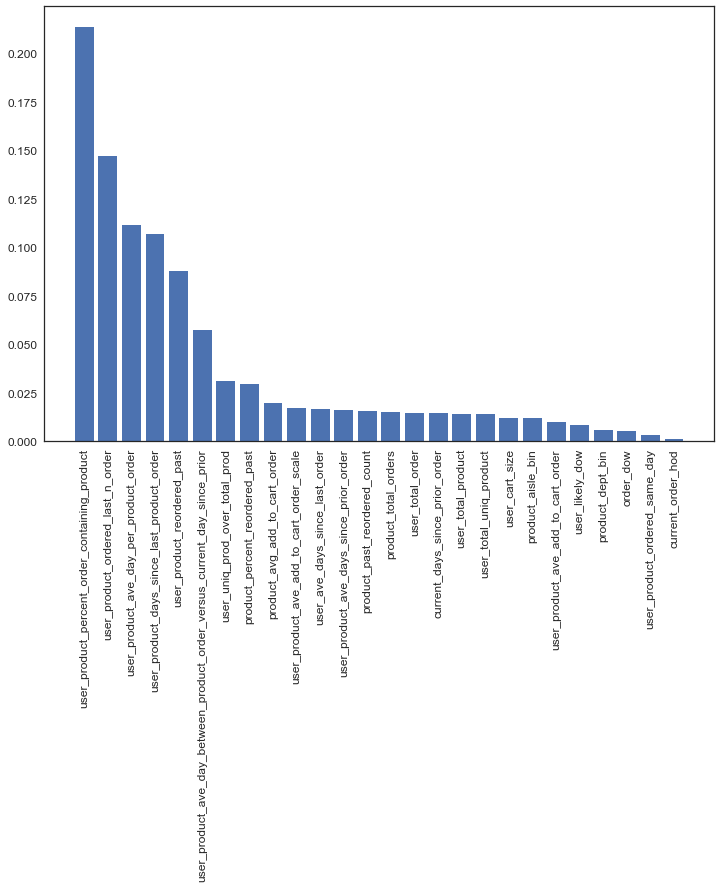

In [138]:
rf, feature_name = sorted(f1s, reverse=True)[0][3:]
importance = [x for x, j in sorted(zip(rf.feature_importances_, feature_names),reverse=True)]
features = [j for x, j in sorted(zip(rf.feature_importances_, feature_names),reverse=True)]

plt.figure(figsize=(12,8))
plt.bar(range(len(importance)), importance)
plt.xticks(range(len(importance)),features, rotation=90);

In [139]:
def cv_xgb(df, cv=5, n_estimators=30000, max_depth=3, objective="binary:logistic", learning_rate=.1, subsample=1, 
           min_child_weight=1, colsample_bytree=.8, v=False):
    rec_list=[]
    prec_list=[]
    f1_list=[]
    auc_list=[]
    f1_train=[]  #check train score if see if the model overfits
    i=0
    highest_f1=[]
    if v:
        fig, ax = plt.subplots(1,3, figsize=(15,5))
    
    kf = KFold(n_splits=cv, shuffle=True)
    for user_train_ind, user_val_ind in kf.split(df.user_id.unique()):
    #print(user_train.shape, user_val.shape)
        user_train=df.user_id.unique()[user_train_ind]
        user_val=df.user_id.unique()[user_val_ind]
        df1 = df[df.user_id.isin(user_train)]
        y_train = df1['reordered']
        X_train = df1.drop(columns=['reordered', 'user_id', 'product_id'])
        feature_names=X_train.columns
        df2 = df[df.user_id.isin(user_val)]
        y_val = df2['reordered']
        X_val = df2.drop(columns=['reordered', 'user_id', 'product_id'])    
        #print(user_train.shape, user_val.shape, X_train.shape, X_val.shape, y_train.shape, y_val.shape)
        
        gbm =  xgb.XGBClassifier( 
                               n_estimators = n_estimators, #arbitrary large number
                               max_depth = max_depth,
                               objective = objective,
                               learning_rate = learning_rate, 
                               subsample = subsample,
                               min_child_weight = min_child_weight,
                               colsample_bytree = colsample_bytree
                                  )
        eval_set=[(X_train,y_train),(X_val,y_val)]
        fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc',
                    early_stopping_rounds=50,
                    verbose=False #gives output log as below
                   )
        y_pred = gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit)
        y_pred_train = gbm.predict(X_train, ntree_limit=gbm.best_ntree_limit)
    
        #acc_list.append(accuracy_score(y_val, y_pred))
        rec_list.append(recall_score(y_val, y_pred))
        prec_list.append(precision_score(y_val, y_pred))
        f1_list.append(f1_score(y_val, y_pred))
        f1_train.append(f1_score(y_train, y_pred_train))
        
        y_pred_prob = gbm.predict_proba(X_val, ntree_limit=gbm.best_ntree_limit)[:,1]
        fpr, tpr, _ = roc_curve(y_val, y_pred_prob, pos_label=1)
        auc_list.append(auc(fpr, tpr))
        if v:
            i += 1
            ax[0].plot(fpr, tpr, label='ROC Fold %d' % i)
        rec, prec, thres = precision_recall_curve(y_val, y_pred_prob, pos_label=1)
        if v:
            ax[1].plot(rec, prec, label ='Fold %d' %i)
        f1s = []
        for r, p, t in zip(rec, prec, thres):
            if r and p:
                f1s.append((2*r*p/(r+p), t, r, p))
        if v:
            print('Fold %d highest F1: %.3f at threshold p= %.3f. Recall is %.3f, precision is %.3f' 
                  % (i, *sorted(f1s, reverse=True)[0]))
        highest_f1.append(sorted(f1s, reverse=True)[0][0])
        if v:
            ax[2].plot(list(zip(*f1s))[1], list(zip(*f1s))[0], label='Fold %d' %i)
    if v:        
        plt.legend()
        ax[0].set_xlabel('FPR')
        ax[0].set_ylabel('TPR')
        ax[0].set_title('ROC Curve')
        ax[1].set_xlabel('Recall')
        ax[1].set_ylabel('Precision')
        ax[1].set_title('Precision-Recall Curve')
        ax[2].set_xlabel('P threshold')
        ax[2].set_ylabel('F1 score')
        ax[2].set_title('F1 Score vs. Positive Class Decision Probability Threshold')

    if v:
        #mean_acc = np.mean(acc_list)
        #std_acc = np.std(acc_list)
        mean_rec = np.mean(rec_list)
        std_rec = np.std(rec_list)
        mean_prec = np.mean(prec_list)
        std_prec = np.std(prec_list) 
        #print('mean accuracy: %.3f, std accuracy: %.3f' % (mean_acc, std_acc))
        print('mean recall: %.3f, std recall: %.3f' % (mean_rec, std_rec))  
        print('mean precision: %.3f, std accuracy: %.3f' % (mean_prec, std_prec))
    
    mean_f1 = np.mean(f1_list)
    std_f1 = np.std(f1_list)
    mean_auc = np.mean(auc_list)
    std_auc = np.std(auc_list)
    mean_f1_train = np.mean(f1_train)
    std_f1_train = np.std(f1_train)
    mean_highest_f1 = np.mean(highest_f1)
    std_highest_f1 = np.std(highest_f1)
    print('mean highest_f1: %.3f, std highest_f1: %.3f' % (mean_highest_f1, std_highest_f1))
    print('mean F1: %.3f, std AUC: %.3f' % (mean_f1, std_f1))
    print('mean AUC: %.3f, std AUC: %.3f' % (mean_auc, std_auc))
    print('mean train F1: %.3f, std train F1: %.3f' % (mean_f1_train, std_f1_train))
    return gbm, feature_names, mean_highest_f1

In [ ]:
f1s=[]
for m in np.linspace(0.02, 0.08, 7):
    for n in [4,5,6,7]:
        print('learning_rate=%f, max_depth=%f' % (m,n))
        gbm,feature_names, f1 = cv_xgb(df=df_hod, 
                                       cv=3, n_estimators=30000, max_depth=n, objective="binary:logistic", 
               learning_rate=m, subsample=0.5, colsample_bytree=0.3, v=False)
        f1s.append((f1, n, m, gbm, feature_names))
print(sorted(f1s, reverse=True)[:5])

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fold 1 highest F1: 0.421 at threshold p= 0.234. Recall is 0.395, precision is 0.450


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fold 2 highest F1: 0.450 at threshold p= 0.258. Recall is 0.448, precision is 0.451


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fold 3 highest F1: 0.437 at threshold p= 0.196. Recall is 0.380, precision is 0.515


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fold 4 highest F1: 0.419 at threshold p= 0.218. Recall is 0.380, precision is 0.466


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fold 5 highest F1: 0.433 at threshold p= 0.217. Recall is 0.393, precision is 0.481
mean recall: 0.174, std recall: 0.011
mean precision: 0.616, std accuracy: 0.026
mean highest_f1: 0.432, std highest_f1: 0.011
mean F1: 0.271, std AUC: 0.016
mean AUC: 0.828, std AUC: 0.007
mean train F1: 0.293, std train F1: 0.005


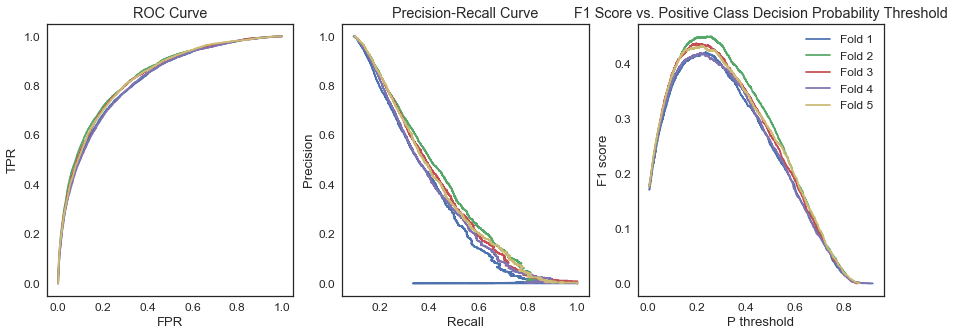

In [140]:
gbm_final,feature_names_final, f1 = cv_xgb(df=df_hod, 
                               cv=5, n_estimators=30000, max_depth=4, objective="binary:logistic", 
       learning_rate=0.025, subsample=0.7, colsample_bytree=0.6, v=True)


**Hyperparameter for the model:**
- n_estimators = 30000, #arbitrary large number
- max_depth = 4,
- objective = "binary:logistic",
- learning_rate = 0.03, 
- subsample = 0.5,
- min_child_weight = 2,
- colsample_bytree = 0.8

**Prediction Threshold** p = 0.2138